## Dataset and Dataloader

데이터 샘플을 처리하는 코드는 지저분하고 유지 보수가 어려울 수 있으므로, 가독성(readability)과 모듈성(modularity)을 위해 데이터셋 코드를 모델 학습 코드로부터 분리하는 것이 이상적이다.
PyTorch는 <code>torch.utils.data.DataLoader</code>와 <code>torch.utils.data.Dataset</code>의 두 가지 데이터 기본 요소를 제공하여 미리 준비해둔 데이터셋 뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 한다.
<code>Dataset</code>은 샘플과 정답(labels)을 저장하고, <code>DataLoader</code>는 <code>Dataset</code>을 샘플에 쉽게 접근할 수 있도록 순회 가능한 객체로 감싼다.


PyTorch의 도메인 특화 라이브러리들은 미리 준비해둔 다양한 데이터셋을 제공한다. 데이터셋은 <code>torch.utils.data.Dataset</code>의 하위 클래스로 개별 데이터를 특정하는 함수가 구현되어 있다. 이러한 데이터셋은 모델을 만들어보고(prototype) 성능을 측정(benchmark) 하는데 사용할 수 있다.

### 데이터셋 불러오기

Fashion-MNIST는 Zalando의 기사 이미지 데이터셋으로 60,000개의 학습 예제와 10,000개의 테스트 예제로 이루어져있다. 각 예저는 흑백(grayscale)의 28X28 이미지와 10개의 분류(class) 중 하나인 정답(label)으로 구성된다.

- <code>root</code>는 학습/테스트 데이터가 저장되는 경로
- <code>train</code>은 학습용 또는 테스트용 데이터셋 여부를 지정함
- <code>download = True</code>는 <code>root</code>에 데이터가 없는 경우 인터넷에서 다운로드함
- <code>transform</code>과 <code>target_transform</code>은 특징(feature)과 정답(label) 변형(transform)을 지정함

In [9]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

### 데이터셋을 순회하고 시각화하기
<code>Dataset</code>에 리스트(list)처럼 직접 접근(index)할 수 있다.
<code>training_data[index]</code>, <code>matplotlib</code>을 사용하여 학습 데이터의 일부를 시각화해보자.

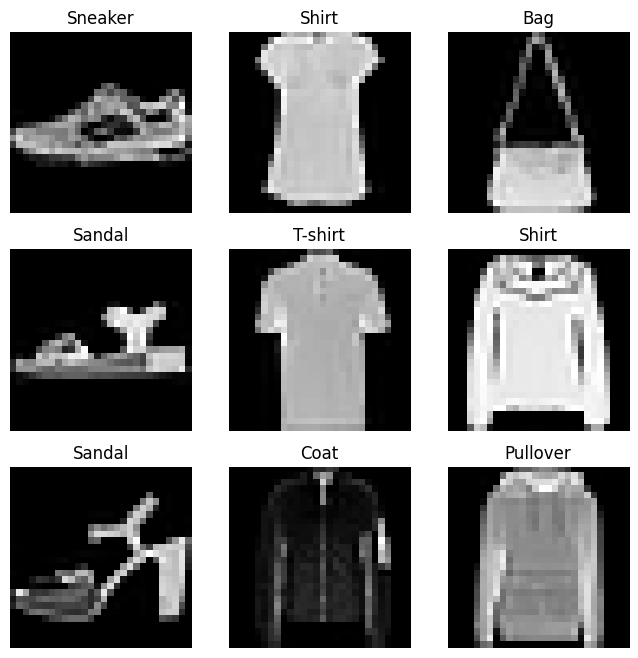

In [10]:
labels_map = {
    0: "T-shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1) :
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()

### 파일에서 사용자 정의 데이터셋 만들기

사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야한다. : __ *init* __, __ *len* __ and __ *getitem* __.
FashinMNIST 이미지들은 <code>img_dir</code> 디렉토리에 저장되고, 정답은 <code>annotations_file</code> csv 파일에 별도로 저장된다.

In [11]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_tansform=None) :
        self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_tansform

    def __len__(self) :
        return len(self.img_labels)
    
    def __getitem__(self, idx) :
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        img = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform :
            image = self.transform(image)
        if self.target_transform :
            label = self.transform(image)
        if self.target_transform :
            label = self.target_transform(label)
        return image, label

### __init__

__init__ 함수는 Dataset 객체가 생성(instantiate) 될 때 한 번만 실행된다. 여기서는 이미지와 주석 파일(annotation_file)이 포함된 디렉토리와 두 가지 변형(transform)을 초기화한다.

In [12]:
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None) :
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

### __len__
__len__ 함수는 데이터셋의 샘플 개수를 반환한다.

In [13]:
def __len__(self) :
    return len(self.img_lables)

### __getitem__

__getitem__ 함수는 주어진 인덱스 <code>idx</code>에 해당하는 샘플을 데이터셋에서 불러오고 반환한다. 인덱스를 기반으로, 디스크에서 이미지의 위치를 식별하고, <code>read_image</code>를 사용하여 이미지를 텐서로 변환하고, <code>self.img_labels</code>의 csv 데이터로부터 해당하는 정답(label)을 가져오고, (해당하는 경우) 변형(transform) 함수들을 호출한 뒤, 텐서 이미지와 라벨을 Python 사전(dict)형으로 반환한다.

In [14]:
def __getitem__(self, idx) :
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform :
        image = self.transform(image)
    if self.target_transform :
        lable = self.target_transform(label)
    sample = {"image" : image, "label" : label}
    return sample

### DataLoader로 학습용 데이터 준비하기

<code>Dataset</code>은 데이터셋의 특징(feature)을 가져오고 하나의 샘플에 정답(label)을 지정하는 일을 한 번에 한다. 모델을 학습할 때, 일반적으로 샘플들을 <미니배치(minibatch)>로 전달하고, 매 에폭(epoch)마다 데이터를 다시 섞어서 과적합(overfit)을 막고, Python의 <code>multiprocessing</code>을 사용하여 데이터 검색 속도를 높이려고 한다.

<code>DataLoader</code>는 간단한 API로 이러한 복잡한 과정들을 추상화한 순회 가능한 객체(iterable)이다.

In [15]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### DataLoader를 통해 순회하기 (iterate)

<code>DataLoader</code>에 데이터셋을 불러온 뒤에는 필요에 따라 데이터셋을 순회(iterate)할 수 있다. 아래의 각 순회(iteration)는 (각각 <code>bath_size = 64</code>의 특징(feature)과 정답(label)을 포함하는) <code>train_features</code>와 <code>train_lables</code>의 묶음(batch)을 반환한다. <code>shuffle=True</code>로 지정했으므로, 모든 배치를 순회한 뒤 데이터가 섞인다. (데이터 불러오기 순서를 보다 세밀하게(fine-grained) 제어하려면 samplers를 공부하자.)

Feature batch shape : torch.Size([64, 1, 28, 28])
Lables batch shape : torch.Size([64])


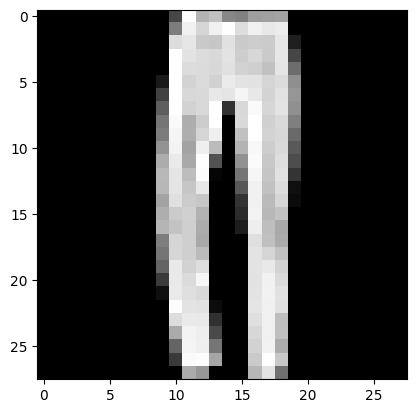

Label : 1


In [16]:
# 이미지와 정답(label)을 표시함
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape : {train_features.size()}")
print(f"Lables batch shape : {train_labels.size()}")
img=train_features[0].squeeze()
label=train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label : {label}")